In [1]:
from MADRLIV import plot_singlepref
from MADRLIV import unique_nontrival_winner
from MADRLIV_sequential import agent_experiment

from MADRLIV import util_from_ranks
import numpy as np
from tqdm.notebook import tqdm
import pickle

In [2]:
mems = [False,'Actions_now'] #types of agent memory to record

agent_types = ['DQN','DQN_truthful','tabular','tabular_truthful'] #types of agent

#mems = [False,'Actions_now']
#agent_types = ['DQN','DQN_truthful']
#agent_types = ['tabular_truthful','tabular']

N_pref=1000

SEQ = False
#use sequential or simultaneous

RES = True
#restrict preference profiles?

DP=False
if N_pref>1:
    DP = True

#produce the preference profile
C = 3 #must be 3
V = 7
CV = (C,V)


alpha = 0.1
alpha_dqn = 0.01
nt = 1
epslen = 500

filename = 'simultaneous_1000_0.1_0.01'
savename = None

A_test = False

In [3]:
"""
for tests in tqdm(range(N_pref)):
    opt,vr, metric_results,plurality_results = unique_nontrival_winner(CV[0],CV[1],'borda',restrict=False)
    pp = [opt,vr]

    results_mix = plot_singlepref(fold=None,mems=mems,agent_types=agent_types,pref_profile=pp,agent_alpha=alpha,N_tests=nt,percent=10,metric='borda_score',eps_len=epslen,updateinterval=2,disablep=DP)

    for k in results_mix.keys():
        reslist = results_mix[k]
        scraped = [result[1] for result in reslist]
        results_mix[k] = scraped

    if vote_histories == {}:
        vote_histories = {key : [] for key in results_mix.keys()}

    for k in results_mix.keys():
        vote_history = [(v.vote_history,v.vote_winners,opt,vr) for v in results_mix[k]]
        vh = vote_histories[k]
        vh = vote_history + vh
        vote_histories[k] = vh
"""


AP = 50
def moving_average(a, n=1):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
if filename is not None:
    if SEQ == False:
        vote_histories = pickle.load(open(filename,"rb"))
    elif SEQ == True:
        vote_histories,vote_histories_seq = pickle.load(open(filename,"rb"))
else:
    total = N_pref*len(agent_types)*len(mems)*nt
    vote_histories = {}
    vote_histories_seq = {}
    pbar = tqdm(total=total)

    for tests in range(N_pref):
        opt,vr, metric_results,plurality_results = unique_nontrival_winner(CV[0],CV[1],'borda',restrict=RES)
        pp = [opt,vr]

        for ag_type in agent_types:
            if 'tabular' in ag_type:
                mems_here = [False]
                correction = int((len(mems)-1)*nt)
                pbar.update(correction)
            else:
                mems_here = mems
            for mem in mems_here:
                
                #Perform repeats for a given agent type

                MA = (mem,ag_type)
                reslist = vote_histories.get(MA,[])
                reslist_seq = vote_histories_seq.get(MA,[])
                for repeat in range(nt):
                    pbar.update(1)
                    if ag_type == 'DQN':
                        a = alpha_dqn
                    elif ag_type == 'DQN_truthful':
                        a = alpha_dqn
                    else:
                        a = alpha
                    bd = agent_experiment(ag_type=ag_type,to_remember=mem,pref_profile=pp,N_episodes=epslen,epsilon=0.1,alpha=a,use_exp=True,neural_update_interval=2,sequential=SEQ)
                    
                    if SEQ == True:
                        final_winners = bd[1]['winners']
                        rewards = bd[1]['rewards']
                        #length = bd[1]['round_lengths']
                        final_vote_history = bd[1]['final_votes']               
                        result = (final_vote_history, final_winners,opt,vr)
                        result_seq = (bd[0].vote_history, bd[0].vote_winners,(bd[0].poll,bd[0].moves),opt,vr)
                        reslist.append(result)
                        reslist_seq.append(result_seq)
                    elif SEQ == False:
                        result = (bd.vote_history, bd.vote_winners,opt,vr)
                        reslist.append(result)
                        

                vote_histories[MA]=reslist
                vote_histories_seq[MA]=reslist_seq


In [5]:
if savename is not None:
    if SEQ == True:
        file = open(savename, 'wb')
        pickle.dump((vote_histories,vote_histories_seq),file)
        file.close()
    elif SEQ == False:
        file = open(savename, 'wb')
        pickle.dump(vote_histories,file)
        file.close()

In [6]:
vote_histories.keys()

dict_keys([(False, 'DQN'), ('Actions_now', 'DQN'), (False, 'DQN_truthful'), ('Actions_now', 'DQN_truthful'), (False, 'tabular'), (False, 'tabular_truthful')])

In [7]:
#%store vote_histories
#%store -r vote_histories
#vote_histories

In [8]:
#leave alone

In [9]:
#“A-ratio,” which is the fraction of instances where action A was played out of all instances where it was available.
#WHERE IT WAS AVAILABLE
#for the 3 candidate situation:

#TRT - Truthful action - voting for candidate with utility 1.00

def scenario_string(poll):
    "Generates the string that identifies which of the 3 options is most, 2nd, least common, ordered by this agents ranking"
    #return str(poll)
    sorted_poll = list(sorted(poll.items(),
                           key=lambda item: item[1],
                           reverse=True))
    pollstr = str([i[0] for i in sorted_poll])

    return pollstr

def determine_move_type_from_utility_of_vote_assigned(utility,utility_last,move):
    #takes in utility score of the chosen option for this and last round - to see if agent moved or stayed and if they compromised or not
    if utility_last == None:
        #first move
        out= 0
    elif utility == utility_last:
        #stay move
        out= 0
    elif utility > utility_last:
        #opportunity move
        out= 1
    elif utility < utility_last:
        #compromise move
        out= -1
    elif (utility,utility_last) == (None,None):
        #fails
        raise InterruptedError
    
    if move == "opportunity":
        return(out==1)
    elif move == "stay":
        return(out==0)
    elif move == "compromise":
        return(out==-1)
    else:
        print(move)
        print("Invalid move/Atype")
        raise InterruptedError
    

def determine_A_type_from_utility_of_vote_assigned(utility,utility_last,winner_history, util_of_vote,A_type,cutoff=10):
    if len(winner_history)<cutoff:
        return False
    elif len(winner_history)==0:
        return False
    else:
        reward_history = [util_of_vote[w] for w in winner_history]
        if cutoff == 0:
            reward_history = reward_history[int(-1*cutoff):]
        poll = {idv : 0 for idv in [1.00,0.5,0.25]}
        for i in reward_history:
            if i in poll.keys():
                poll[i] = poll[i] + 1

        #print()
        #print(utility,poll)
        #print("TRT:{}\nDOM:{}\nLB:{}\nCMP:{}".format(float(TRT(utility)),float(DOM(utility,poll)),float(LB(utility,poll)),float(CMP(utility,poll))))
        #print()

      
        if A_type == "scenario":
            return scenario_string(poll)
        else:
            return determine_move_type_from_utility_of_vote_assigned(utility,utility_last,A_type)

def convert_to_numbers(winlist,options):
    return np.array([options.index(i) for i in winlist])

In [10]:
from voting_tools import Aggregator, find_winner

def fullscan(history,nobar=False):
    """
    Scans the entire sequence of runs for a given history (particular agent setup) and returns mean linear reward, exponential reward, borda score, condorcet eff, number of profiles with a condorcet winner and number of profiles scanned.
    """
    results_dict = {}
    reward_lin = None
    reward_exp = None

    cw_exists = 0

    borda_score = None
    condorcet = None

    for history_comps in tqdm(history,desc='rewards',disable=nobar):
        run,options_round,vr_round = history_comps[0],history_comps[2],history_comps[3]
        agents = len(vr_round)
        repeats = len(history)

        agg = Aggregator(inputs=(options_round,vr_round))

        bordas = agg.borda()
        condorcet = find_winner(agg.pairwise_comparison())
        
        if len(condorcet) > 1:
            cw = None
        elif len(condorcet) == 1:
            cw = condorcet[0]
            cw_exists += 1
        
        win_letters = history_comps[1]

        entire_winner_history = convert_to_numbers(history_comps[1],options=options_round)

        if reward_lin is None:
            reward_lin = np.zeros(len(run))
            reward_exp = np.zeros(len(run))            
            condorcet_winner = np.zeros(len(run))
            borda_score = np.zeros(len(run))

        for eps_number,step in enumerate(run):
            for agent_num,vote in enumerate(step):

                agents_prefs = vr_round[agent_num]
                #need to store specific agent rank not overall!!
                util_of_vote = util_from_ranks(rank_list=agents_prefs,options=options_round,use_exp=True)
                lin_util_of_vote = util_from_ranks(rank_list=agents_prefs,options=options_round,use_exp=False)
                
                thiswin = entire_winner_history[eps_number]
                reward_lin[eps_number] += float(lin_util_of_vote[thiswin])
                reward_exp[eps_number] += float(util_of_vote[thiswin])

            winletter = win_letters[eps_number]
            if cw is not None:
                condorcet_winner[eps_number] += float(winletter==cw)
            borda_score[eps_number] += float(bordas[winletter])

                
    factor = agents*repeats

    return np.array(reward_lin/factor),np.array(reward_exp/factor),np.array(borda_score/factor),np.array(condorcet_winner/cw_exists),cw_exists,repeats

In [11]:
def generate_action_table_seq(history,aggregate_interval):
    """
    For a given segment of a particular agent type (memory type, agent type name), and an aggregate interval tup, scans the entire interval on all repeats and classifies action types
    Uses the current round votes as the 'poll' to determine a ratios - use only with vote history sequential
    """
    results_dict = {}
    total_acts = 0
    total_rews = 0


    for hn,history_comps in enumerate(tqdm(history,desc='full table',disable=True)):
        
        run, _ ,poll_moves,options_round,vr_round = history_comps
        
        poll_cutoff = 0
        polls, moves = poll_moves

        
        start, end = int(aggregate_interval[0]*len(run)), int(aggregate_interval[1]*len(run))
        
        #print(start,end)
        #should AVERAGE to these number of episode
        
        run = run[start:end]
        polls = polls[start:end]
        moves = moves[start:end]

        for eps_number,step in enumerate(run):

            poll = polls[eps_number]

            agent_num = moves[eps_number]
            
            agents_prefs = vr_round[agent_num]
            #need to store specific agent rank not overall!!

            util_of_vote = util_from_ranks(rank_list=agents_prefs,options=options_round,use_exp=True)


            vote = step[agent_num]

            
            #utility of what the agent is voting FOR


            try:
                utility = util_of_vote[vote]               
            except Exception as E:
                print(E)
                utility = 0.25
            
            #takes in utility of this last vote, the history of which option numbers won and the preference profile over numbers (util of vote) to determine agent behaviour
            in_poll = []
            for p in poll:
                if p is not None:
                    in_poll.append(p)

            scenario = determine_A_type_from_utility_of_vote_assigned(utility,None,in_poll, util_of_vote,A_type='scenario',cutoff=poll_cutoff)



           
            scen_results = results_dict.get(scenario,np.zeros(3))

            rank_idx = int(-1*np.log2(utility))

            scen_results[rank_idx] += 1

            if A_test == True:
                print(hn,eps_number,agent_num,in_poll,vote,step, agents_prefs, scenario,scen_results)

            results_dict[scenario] = scen_results

            total_acts += 1
    
    results_dict['total'] = total_acts
    results_dict['rews'] = 0

    return results_dict


In [12]:
if SEQ == True:
    if A_test == True:
        print("Hist_number","eps_number","agent_num","poll","this_vote","current_vote_sit", "agents_prefs", "scenario agent is in", "scenario_counts")
        generate_action_table_seq(vote_histories_seq[(False,'tabular')],(0.00,0.02))

In [13]:
def generate_action_table(history,aggregate_interval,poll_cutoff=10):
    """
    For a given segment of a particular agent type (memory type, agent type name), and an aggregate interval tup, scans the entire interval on all repeats and classifies action types
    Uses the last poll_cutoff votes as the 'poll' to determine a ratios - use only with vote history (NOT sequential)

    """

    results_dict = {}
    total_acts = 0
    total_rews = 0

    for history_comps in tqdm(history,desc='full table',disable=True):
        
        run,options_round,vr_round = history_comps[0],history_comps[2],history_comps[3]

        entire_winner_history = convert_to_numbers(history_comps[1],options=options_round)
        
        start, end = int(aggregate_interval[0]*len(run)), int(aggregate_interval[1]*len(run))

        run = run[start:end]
        entire_winner_history = entire_winner_history[start:end]

        for eps_number,step in enumerate(run):
            if eps_number>1:
                winner_history = entire_winner_history[:eps_number-1]
            else:
                winner_history = []

            for agent_num,vote in enumerate(step):
                agents_prefs = vr_round[agent_num]
                #need to store specific agent rank not overall!!
                util_of_vote = util_from_ranks(rank_list=agents_prefs,options=options_round,use_exp=True)
                lin_util_of_vote = util_from_ranks(rank_list=agents_prefs,options=options_round,use_exp=False)
                
                #utility of what the agent is voting FOR
                utility = util_of_vote[vote]               
                
                #takes in utility of this last vote, the history of which option numbers won and the preference profile over numbers (util of vote) to determine agent behaviour
                scenario = determine_A_type_from_utility_of_vote_assigned(utility,None,winner_history, util_of_vote,A_type='scenario',cutoff=poll_cutoff)

                thiswin = entire_winner_history[eps_number]
                total_rews += lin_util_of_vote[thiswin]
                
                scen_results = results_dict.get(scenario,np.zeros(3))

                
                rank_idx = int(-1*np.log2(utility))

                scen_results[rank_idx] += 1

                if A_test == True:
                    print(eps_number,agent_num,vote,step, agents_prefs, scenario,scen_results)

                results_dict[scenario] = scen_results

                total_acts += 1
    
    results_dict['total'] = total_acts
    results_dict['rews'] = total_rews

    return results_dict

In [14]:
if SEQ == False:
    if A_test == True:
        print(generate_action_table(vote_histories[(False,'tabular')],(0.00,0.1)))

if A_test == True:
    raise InterruptedError

In [15]:
def A_ratio_from_res(act_results,scenarios,A_list):
    """
    Using the rules given in Meir (2020) (given in scenarios and A_list), directly assess action taken in each poll situation (act_results).
    return A_ratios list for each
    """
    A_available={1:[['TRT'],['DOM'],['DOM']],
            2:[['TRT'],['DOM'],['DOM']],
            3:[['TRT'],['LB'],['DOM']],
            4:[['TRT'],['DOM'],['DOM','LB']],
            5:[['TRT'],['CMP','LB','CMP+LB'],['DOM']],
            6:[['TRT'],['CMP'],['DOM','LB','DOM+LB']]}
    scenarios_nums = [1,2,3,4,5,6]

    flatt = lambda list_of_lists : [y for x in list_of_lists for y in x]

    A_ratios = []
    for act_name in A_list:
        opportunities = 0
        a_taken = 0
        for scenario_num in scenarios_nums:
            
            actions_scenario = A_available[scenario_num]

            scenarios_name = scenarios[scenario_num]

            counts_scenario = act_results[scenarios_name]

            if act_name in flatt(actions_scenario):
                opportunities += np.sum(counts_scenario)
                for idx,count in enumerate(counts_scenario):
                    if act_name in actions_scenario[idx]:
                        a_taken += count
        A_ratios.append(tuple((int(opportunities),int(a_taken),round(a_taken/opportunities,3))))
    return A_ratios

In [16]:
POLC=10

def plot_function(frame):
    """
    For animated plot of SINGLE agent, plots action type table as well
    """
    scenarios={
    4:'[0.25, 1.0, 0.5]',
    2:'[1.0, 0.25, 0.5]',
    3:'[0.5, 1.0, 0.25]',
    5:'[0.5, 0.25, 1.0]',
    1:'[1.0, 0.5, 0.25]',
    6:'[0.25, 0.5, 1.0]',
    0:'total'}


    frames = np.linspace(0,1-interval,NF)
    start = frames[frame]
    ax.clear()

    if SEQ == False:
        act_results = generate_action_table(sample,(start,start+interval),poll_cutoff=POLC)
    elif SEQ == True:
        act_results = generate_action_table_seq(sample,(start,start+interval))        

    A_list = ['TRT','LB','DOM+LB','CMP','CMP+LB','DOM']
    try:
        A_results = A_ratio_from_res(act_results=act_results,scenarios=scenarios,A_list=A_list)
    except KeyError as K:
        print(K)
        print("Not all scenarios possible, adjust C,V!")
        for a in act_results.keys():
            print(a,act_results[a])
        raise InterruptedError

    ax.set_title("Mean linear reward = {}".format(round(act_results['rews']/act_results['total'],4)))

    metrics_string = "scenario : ordering : 1st, 2nd, 3rd : total"
    for number in sorted(scenarios.keys()):
        k = scenarios[number]
        if k != 'total':
            if k!= 'reward':
                line = "\n{}:{}:{}:{}".format(number,k,np.round(act_results[k]/np.sum(act_results[k]),3),int(np.sum(act_results[k])))
                metrics_string += line


    AS = [A[2] for A in A_results]

    x = np.arange(len(AS))


    A_ticks = A_list
    for idx,A in enumerate(A_ticks):
        ari = [str(x) for x in A_results[idx]]
        A = A+'\n'+"\n".join(ari)
        A_ticks[idx] = A

    ax.bar(x,AS,tick_label=A_ticks,width=0.2,label='RL/simultaneous, {}-{}'.format(int(start*epslen),int((interval+start)*epslen)))
    paper_vals = [0.7,0.48,0.12,0.48,0.72,0.02]
    ax.bar(x+0.2,paper_vals,width=0.2,label='Humans/sequential, 0-5/10')
    ax.text(0,1.0,s=metrics_string)
    ax.legend()
    ax.set_ylim(0.0,1.2)

In [17]:
import matplotlib.animation as animation
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rc
rc('animation', html='jshtml')


In [18]:
def plot_param(scan,avp,name):
    lin,exp,borda,condorcet,cr,reps = fullscan(scan)
    lin,exp,borda,condorcet = [moving_average(x,avp) for x in [lin,exp,borda,condorcet]]
    condorcet_reps, reps = cr/nt, reps/nt
    out_array = np.vstack((lin,exp,borda,condorcet)).T
    df = pd.DataFrame(out_array, columns = ['{} Linear Reward {}'.format(name,reps),'{} Exponential Reward {}'.format(name,reps),'{} Borda Score/Max {}'.format(name,reps),'{} Condorcet efficiency {}'.format(name, condorcet_reps)])
    return df

avp = 10
results_plot = []
for ref in vote_histories.keys():
    results_plot.append(plot_param(vote_histories[ref],avp,str(ref)))

In [19]:
from scipy.stats import ttest_rel
from scipy.stats import sem

In [20]:
interval = 0.02

#np.array(reward_lin/factor),np.array(reward_exp/factor),np.array(borda_score/factor),np.array(condorcet_winner/cw_exists),cw_exists,repeats

index_names = ['Linear Reward','Exponential Reward','Borda Score/Max', 'Condorcet efficiency']

results = {}
t_results = {}

for ref in tqdm(vote_histories.keys()):
    round_hist = vote_histories[ref]

    N_runs = len(round_hist)

    hist_results_start = np.zeros((N_runs,4))
    hist_results_end = np.zeros((N_runs,4))

    

    for r in range(N_runs):
        rh = [round_hist[r]]
        raw_output = list(fullscan(rh,nobar=True))
        #print(raw_output)

        start_cut = int(interval*len(raw_output[0]))
        end_cut = int((1-interval)*len(raw_output[0]))
        total = len(raw_output[0])

        for pidx,param in enumerate(raw_output):
            #print(len(param))

            #print(len(raw_output))

            #print(first,last)

            if pidx<4:
                first = np.mean(param[:start_cut])
                last = np.mean(param[end_cut:])
                #print(pidx,first,last)

                hist_results_start[r,pidx] = first
                hist_results_end[r,pidx] = last
    
    #print()
    #print(ref)
    #print("Linear Reward, Exp Reward, Borda Score, Condorcet Eff. means, stds:")
    #print("First {}:".format(start_cut),np.nanmean(hist_results_start,axis=0),np.nanstd(hist_results_start,axis=0))
    #print("Last {}-{}:".format(end_cut,total),np.nanmean(hist_results_end,axis=0),np.nanstd(hist_results_end,axis=0))

    ttest_results = ttest_rel(hist_results_start,hist_results_end,axis=0)
    print(ref)
    print(ttest_results)


    make_res_str = lambda results, errors: ["{}±{}".format(round(result,3),round(error,3)) for result, error in zip(results,errors)]

    

    combi = lambda st,en : ["{} ... {}".format(s,e) for s,e in zip(st,en)]

    res_start = make_res_str(np.nanmean(hist_results_start,axis=0),sem(hist_results_start,axis=0,nan_policy='omit'))
    res_end = make_res_str(np.nanmean(hist_results_end,axis=0),sem(hist_results_end,axis=0,nan_policy='omit'))

    round_outstring = combi(res_start,res_end)

    results[str(ref)] = round_outstring
    t_results[str(ref)] = ["{}".format(round(T,3)) for T in ttest_results.statistic]

infostring = "First {}, Last {}-{}".format(start_cut,end_cut,total)

(False, 'DQN')
Ttest_relResult(statistic=array([ -8.52156159, -15.89617807,  -8.52156159,          nan]), pvalue=array([3.05074920e-17, 1.13521193e-53, 3.05074920e-17,            nan]))
('Actions_now', 'DQN')
Ttest_relResult(statistic=array([-11.89593347, -16.82470358, -11.89593347,          nan]), pvalue=array([1.40622807e-31, 1.64302341e-59, 1.40622807e-31,            nan]))
(False, 'DQN_truthful')
Ttest_relResult(statistic=array([-16.17674484,  -0.02803236, -16.17674484,          nan]), pvalue=array([2.07550087e-55, 9.77639142e-01, 2.07550087e-55,            nan]))
('Actions_now', 'DQN_truthful')
Ttest_relResult(statistic=array([-18.45528829,  -0.42759224, -18.45528829,          nan]), pvalue=array([2.36833628e-70, 6.68994073e-01, 2.36833628e-70,            nan]))
(False, 'tabular')
Ttest_relResult(statistic=array([-19.62525745, -17.50374621, -19.62525745,          nan]), pvalue=array([1.45732820e-78, 6.15658308e-64, 1.45732820e-78,            nan]))
(False, 'tabular_truthful')
Ttes

In [21]:
print(infostring)
results = pd.DataFrame(results,index_names)
results_t = pd.DataFrame(t_results,index=index_names)
results

First 10, Last 490-501


(False, 'DQN')  \
Linear Reward         1.001±0.003 ... 1.036±0.002   
Exponential Reward    0.583±0.001 ... 0.604±0.001   
Borda Score/Max       1.001±0.003 ... 1.036±0.002   
Condorcet efficiency  0.329±0.009 ... 0.366±0.008   

                           ('Actions_now', 'DQN')  \
Linear Reward         0.996±0.003 ... 1.044±0.002   
Exponential Reward    0.583±0.001 ... 0.604±0.001   
Borda Score/Max       0.996±0.003 ... 1.044±0.002   
Condorcet efficiency  0.327±0.009 ... 0.406±0.008   

                          (False, 'DQN_truthful')  \
Linear Reward           1.0±0.002 ... 1.032±0.002   
Exponential Reward    0.604±0.001 ... 0.604±0.001   
Borda Score/Max         1.0±0.002 ... 1.032±0.002   
Condorcet efficiency  0.192±0.006 ... 0.341±0.008   

                     ('Actions_now', 'DQN_truthful')  \
Linear Reward            0.998±0.002 ... 1.036±0.002   
Exponential Reward       0.603±0.001 ... 0.603±0.001   
Borda Score/Max          0.998±0.002 ... 1.036±0.002   
Condorcet efficiency     0.187±0.006 ... 0.373±0.008   

                               (False, 'tabular')  (False, 'tabular_truthful')  
Linear Reward         1.004±0.003 ... 1.079±0.003    1.0±0.002 ... 1.066±0.003  
Exponential Reward    0.584±0.001 ... 0.605±0.001  0.603±0.001 ... 0.607±0.001  
Borda Score/Max       1.004±0.003 ... 1.079±0.003    1.0±0.002 ... 1.066±0.003  
Condorcet efficiency   0.331±0.009 ... 0.527±0.01  0.189±0.006 ... 0.496±0.009

In [22]:
results_t

(False, 'DQN') ('Actions_now', 'DQN')  \
Linear Reward                -8.522                -11.896   
Exponential Reward          -15.896                -16.825   
Borda Score/Max              -8.522                -11.896   
Condorcet efficiency            nan                    nan   

                     (False, 'DQN_truthful') ('Actions_now', 'DQN_truthful')  \
Linear Reward                        -16.177                         -18.455   
Exponential Reward                    -0.028                          -0.428   
Borda Score/Max                      -16.177                         -18.455   
Condorcet efficiency                     nan                             nan   

                     (False, 'tabular') (False, 'tabular_truthful')  
Linear Reward                   -19.625                     -27.265  
Exponential Reward              -17.504                      -8.627  
Borda Score/Max                 -19.625                     -27.265  
Condorcet efficiency                nan                         nan

In [23]:
results_plot=pd.concat(results_plot,axis=0)

In [24]:
def rationalize_headers(index_list):
    out = []
    for i in index_list:
        actual = ""
        start,end = i.split(") ")
        if 'DQN' in start:
            actual += 'DQN '
        elif 'tabular' in start:
            actual += 'Tabular '
        
        if 'truthful' in start:
            actual += 'truthful '
        
        if 'Actions_now' in start:
            actual += 'observant '
        
        name = actual + end
        out.append(name[:-7])
    return out

results_plot.columns = rationalize_headers(results_plot.columns)

In [25]:
fig = px.line(results_plot)
fig.update_layout(
    margin=dict(l=20, r=30, t=35, b=20),width=1200,
    height=800,yaxis=dict(
        title_text="Value"),xaxis=dict(
        title_text="Episode number")
)
fig.show()

In [26]:
"""
def A_results_agent(vote_seq,interval):
    scenarios={
    4:'[0.25, 1.0, 0.5]',
    2:'[1.0, 0.25, 0.5]',
    3:'[0.5, 1.0, 0.25]',
    5:'[0.5, 0.25, 1.0]',
    1:'[1.0, 0.5, 0.25]',
    6:'[0.25, 0.5, 1.0]',
    0:'total'}


    start = int(interval*len(vote_seq))
    end = int((1-interval)*len(vote_seq))

    if SEQ == False:
        act_results_start = generate_action_table(vote_seq,(start,start+interval),poll_cutoff=POLC)
        act_results_end = generate_action_table(vote_seq,(end,end+interval),poll_cutoff=POLC)
    elif SEQ == True:
        act_results_start = generate_action_table_seq(vote_seq,(start,start+interval))
        act_results_end = generate_action_table_seq(vote_seq,(end,end+interval))                

    A_list = ['TRT','LB','DOM+LB','CMP','CMP+LB','DOM']
    try:
        A_results_start = A_ratio_from_res(act_results=act_results_start,scenarios=scenarios,A_list=A_list)
        A_results_end = A_ratio_from_res(act_results=act_results_end,scenarios=scenarios,A_list=A_list)
    except KeyError as K:
        print(K)
        print("Not all scenarios possible, adjust C,V!")
        for a in act_results.keys():
            print(a,act_results[a])
        raise InterruptedError

    return A_results_start,A_results_end
"""

'\ndef A_results_agent(vote_seq,interval):\n    scenarios={\n    4:\'[0.25, 1.0, 0.5]\',\n    2:\'[1.0, 0.25, 0.5]\',\n    3:\'[0.5, 1.0, 0.25]\',\n    5:\'[0.5, 0.25, 1.0]\',\n    1:\'[1.0, 0.5, 0.25]\',\n    6:\'[0.25, 0.5, 1.0]\',\n    0:\'total\'}\n\n\n    start = int(interval*len(vote_seq))\n    end = int((1-interval)*len(vote_seq))\n\n    if SEQ == False:\n        act_results_start = generate_action_table(vote_seq,(start,start+interval),poll_cutoff=POLC)\n        act_results_end = generate_action_table(vote_seq,(end,end+interval),poll_cutoff=POLC)\n    elif SEQ == True:\n        act_results_start = generate_action_table_seq(vote_seq,(start,start+interval))\n        act_results_end = generate_action_table_seq(vote_seq,(end,end+interval))                \n\n    A_list = [\'TRT\',\'LB\',\'DOM+LB\',\'CMP\',\'CMP+LB\',\'DOM\']\n    try:\n        A_results_start = A_ratio_from_res(act_results=act_results_start,scenarios=scenarios,A_list=A_list)\n        A_results_end = A_ratio_from_res

In [27]:
#A_results_agent(vote_seq=vote_histories[(False,'tabular')],interval=0.2)

In [28]:
"""
interval = 0.01

#np.array(reward_lin/factor),np.array(reward_exp/factor),np.array(borda_score/factor),np.array(condorcet_winner/cw_exists),cw_exists,repeats

index_names = ['TRT','LB','DOM+LB','CMP','CMP+LB','DOM']

results = {}
t_results = {}

for ref in tqdm(vote_histories.keys()):
    round_hist = vote_histories[ref]

    N_runs = len(round_hist)

    hist_results_start = np.zeros((N_runs,6))
    hist_results_end = np.zeros((N_runs,6))

    rh = round_hist
    A_start,A_end = A_results_agent(vote_seq=round_hist,interval=interval)

    print(ref,A_start,A_end)

    first = np.array(A_start)
    last = np.array(A_end)
    #print(raw_output)


    for pidx,param in enumerate(raw_output):
        hist_results_start[r,pidx] = first
        hist_results_end[r,pidx] = last
    
    #print()
    #print(ref)
    #print("Linear Reward, Exp Reward, Borda Score, Condorcet Eff. means, stds:")
    #print("First {}:".format(start_cut),np.nanmean(hist_results_start,axis=0),np.nanstd(hist_results_start,axis=0))
    #print("Last {}-{}:".format(end_cut,total),np.nanmean(hist_results_end,axis=0),np.nanstd(hist_results_end,axis=0))

    ttest_results = ttest_rel(hist_results_start,hist_results_end,axis=0)
    print(ref)
    print(ttest_results)


    make_res_str = lambda results, errors: ["{}±{}".format(round(result,3),round(error,3)) for result, error in zip(results,errors)]

    

    combi = lambda st,en : ["{} ... {}".format(s,e) for s,e in zip(st,en)]

    res_start = make_res_str(np.nanmean(hist_results_start,axis=0),sem(hist_results_start,axis=0,nan_policy='omit'))
    res_end = make_res_str(np.nanmean(hist_results_end,axis=0),sem(hist_results_end,axis=0,nan_policy='omit'))

    round_outstring = combi(res_start,res_end)

    results[str(ref)] = round_outstring
    t_results[str(ref)] = ["{}".format(round(T,3)) for T in ttest_results.statistic]

infostring = "First {}, Last {}-{}".format(start_cut,end_cut,total)

"""
print("dud")

dud


In [29]:
print(infostring)
results = pd.DataFrame(results,index_names)
results_t = pd.DataFrame(t_results,index=index_names)
results

First 10, Last 490-501


(False, 'DQN')  \
Linear Reward         1.001±0.003 ... 1.036±0.002   
Exponential Reward    0.583±0.001 ... 0.604±0.001   
Borda Score/Max       1.001±0.003 ... 1.036±0.002   
Condorcet efficiency  0.329±0.009 ... 0.366±0.008   

                           ('Actions_now', 'DQN')  \
Linear Reward         0.996±0.003 ... 1.044±0.002   
Exponential Reward    0.583±0.001 ... 0.604±0.001   
Borda Score/Max       0.996±0.003 ... 1.044±0.002   
Condorcet efficiency  0.327±0.009 ... 0.406±0.008   

                          (False, 'DQN_truthful')  \
Linear Reward           1.0±0.002 ... 1.032±0.002   
Exponential Reward    0.604±0.001 ... 0.604±0.001   
Borda Score/Max         1.0±0.002 ... 1.032±0.002   
Condorcet efficiency  0.192±0.006 ... 0.341±0.008   

                     ('Actions_now', 'DQN_truthful')  \
Linear Reward            0.998±0.002 ... 1.036±0.002   
Exponential Reward       0.603±0.001 ... 0.603±0.001   
Borda Score/Max          0.998±0.002 ... 1.036±0.002   
Condorcet efficiency     0.187±0.006 ... 0.373±0.008   

                               (False, 'tabular')  (False, 'tabular_truthful')  
Linear Reward         1.004±0.003 ... 1.079±0.003    1.0±0.002 ... 1.066±0.003  
Exponential Reward    0.584±0.001 ... 0.605±0.001  0.603±0.001 ... 0.607±0.001  
Borda Score/Max       1.004±0.003 ... 1.079±0.003    1.0±0.002 ... 1.066±0.003  
Condorcet efficiency   0.331±0.009 ... 0.527±0.01  0.189±0.006 ... 0.496±0.009

In [30]:
POLC=10
interval = 0.1
print_table = True

def combi_plot_function(frame,sample,delta_x,name,first,width):
    scenarios={
    4:'[0.25, 1.0, 0.5]',
    2:'[1.0, 0.25, 0.5]',
    3:'[0.5, 1.0, 0.25]',
    5:'[0.5, 0.25, 1.0]',
    1:'[1.0, 0.5, 0.25]',
    6:'[0.25, 0.5, 1.0]',
    0:'total'}


    frames = np.linspace(0,1-interval,NF)
    start = frames[frame]

    if SEQ == False:
        act_results = generate_action_table(sample,(start,start+interval),poll_cutoff=POLC)
    elif SEQ == True:
        act_results = generate_action_table_seq(sample,(start,start+interval))        

    A_list = ['TRT','LB','DOM+LB','CMP','CMP+LB','DOM']
    try:
        A_results = A_ratio_from_res(act_results=act_results,scenarios=scenarios,A_list=A_list)
    except KeyError as K:
        print(K)
        print("Not all scenarios possible, adjust C,V!")
        for a in act_results.keys():
            print(a,act_results[a])
        raise InterruptedError

    #ax.set_title("Mean linear reward = {}".format(round(act_results['rews']/act_results['total'],4)))

    metrics_string = "scenario : ordering : 1st, 2nd, 3rd : total"
    for number in sorted(scenarios.keys()):
        k = scenarios[number]
        if k != 'total':
            if k!= 'reward':
                line = "\n{}:{}:{}:{}".format(number,k,np.round(act_results[k]/np.sum(act_results[k]),3),int(np.sum(act_results[k])))
                metrics_string += line
    


    AS = [A[2] for A in A_results]

    if print_table == True:
        A_results_dicts[frame][name]=AS

    x = np.arange(len(AS))


    A_ticks = A_list
    #for idx,A in enumerate(A_ticks):
    #    ari = [str(x) for x in A_results[idx]]
    #    A = A+'\n'+"\n".join(ari)
    #    A_ticks[idx] = A

    ax.bar(x+delta_x,AS,width=width,tick_label = A_ticks,label='{}/seq:{}, {}-{}'.format(name,SEQ,int(start*epslen),int((interval+start)*epslen)))
    paper_vals = [0.7,0.48,0.12,0.48,0.72,0.02]
    if first == True:
        ax.bar(x,paper_vals,width=width,label='Humans/sequential, 0-5/10')
    #ax.text(0,1.0,s=metrics_string)S
    ax.legend()
    ax.set_ylim(0.0,1.2)

def unif_plot_function(frame):
    ax.clear()
    keys = list(hist.keys())
    total = len(keys)

    delta = 0.5/float(total)

    for idx,k in enumerate(keys):
        if idx == 0:
            first = True
        else:
            first = False
        
        #if SEQ == True:
        #    lens = np.mean([len(x[0]) for x in hist[k]])
        #    print("Episode numbers are AVERAGE only - mean total rounds {}, mean round length {}".format(int(lens),int(lens/epslen)))

        x_shift = delta*(idx+1)
        combi_plot_function(frame,hist[k],x_shift,str(k),first,width=delta)
    if print_table == True:
        print(A_results_dicts)

[{"(False, 'DQN')": [0.395, 0.41, 0.348, 0.442, 0.473, 0.397], "('Actions_now', 'DQN')": [0.431, 0.374, 0.314, 0.427, 0.457, 0.373], "(False, 'DQN_truthful')": [0.932, 0.034, 0.033, 0.037, 0.034, 0.058], "('Actions_now', 'DQN_truthful')": [0.903, 0.049, 0.048, 0.086, 0.069, 0.075], "(False, 'tabular')": [0.346, 0.492, 0.457, 0.429, 0.504, 0.438], "(False, 'tabular_truthful')": [0.928, 0.039, 0.033, 0.042, 0.054, 0.06]}, {}, {}, {}, {}, {}, {}, {}, {}, {}]


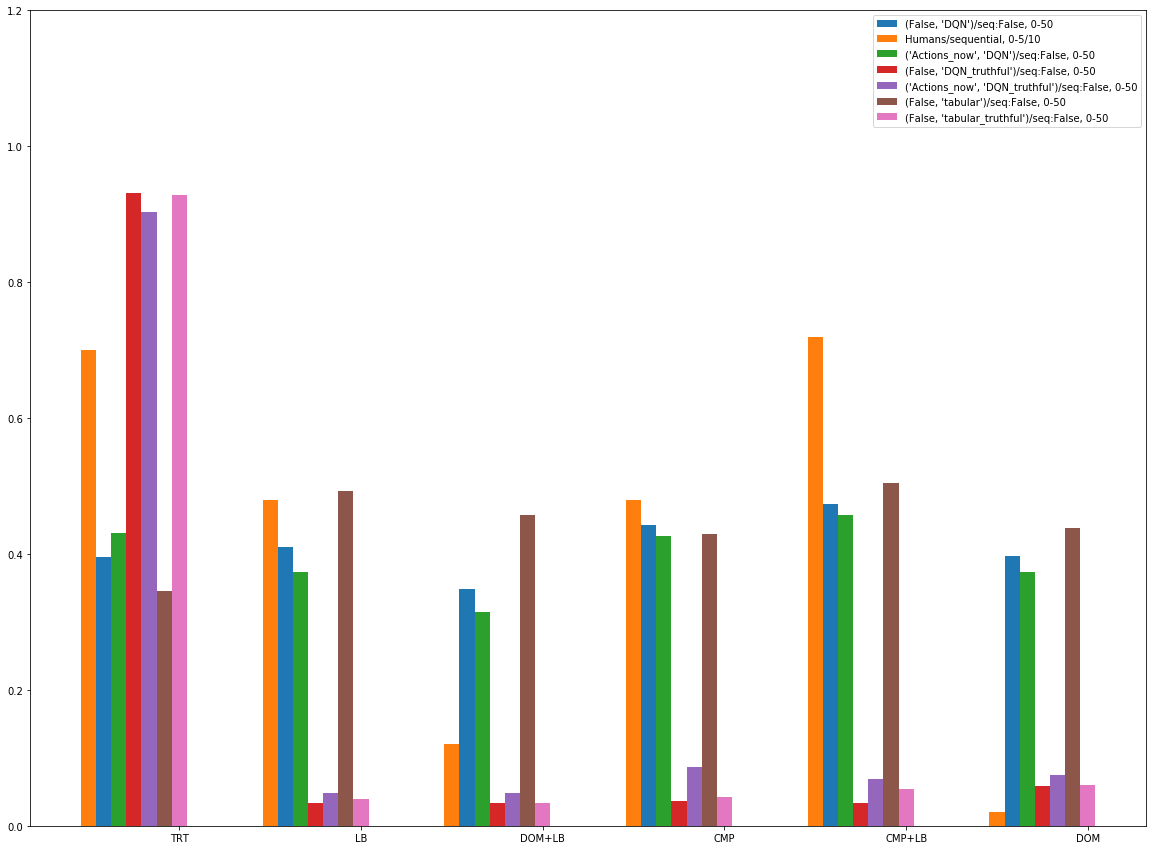

In [31]:
NF = 10
if print_table == True:
    A_results_dicts = [{} for x in range(NF)]
frange = tqdm(range(NF))
if SEQ == True:
    hist = vote_histories_seq
else:
    hist = vote_histories
fig, ax = plt.subplots(figsize=(20, 15))
anim = animation.FuncAnimation(fig, unif_plot_function, frames=frange, blit=False, repeat=False)

In [32]:
#raise InterruptedError

In [33]:
if SEQ == True:
    print("RL Agents")
    print("Sequential Iterative Voting")
    print("candidates: {}\nvoters: {}\nnumber of iterations: {}\nnumber of preference profiles: {}\nnumber of repeats per profile: {}\ntotal number of runs: {}\ntotal episodes: {}\ntotal data points (runs * voters * eps length): {}".format(\
        CV[0],CV[1],interval,N_pref,nt,int(N_pref*nt),int(N_pref*nt*interval),int(N_pref*nt*V*interval)))

    print("\n\nHumans - Meir 2020")
    print("candidates: {}\nvoters: {}\nnumber of iterations: {}\nnumber of preference profiles: {}\nnumber of repeats per profile: {}".format(\
        3,7,"5-10",6,"?"))

#began with agents voting truthfully
#voting was sequential - 'Actions_now', not 'poll' estimate
#no tiebreak
#linear rewards
#terminated on convergence

# Subjects could play up to 6 games in a sequence, each time with a different preference profile
#2 with no cw, 2 with cw=pw, 2 with cw not plurality

In [34]:
anim

[{"(False, 'DQN')": [0.395, 0.41, 0.348, 0.442, 0.473, 0.397], "('Actions_now', 'DQN')": [0.431, 0.374, 0.314, 0.427, 0.457, 0.373], "(False, 'DQN_truthful')": [0.932, 0.034, 0.033, 0.037, 0.034, 0.058], "('Actions_now', 'DQN_truthful')": [0.903, 0.049, 0.048, 0.086, 0.069, 0.075], "(False, 'tabular')": [0.346, 0.492, 0.457, 0.429, 0.504, 0.438], "(False, 'tabular_truthful')": [0.928, 0.039, 0.033, 0.042, 0.054, 0.06]}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
[{"(False, 'DQN')": [0.395, 0.41, 0.348, 0.442, 0.473, 0.397], "('Actions_now', 'DQN')": [0.431, 0.374, 0.314, 0.427, 0.457, 0.373], "(False, 'DQN_truthful')": [0.932, 0.034, 0.033, 0.037, 0.034, 0.058], "('Actions_now', 'DQN_truthful')": [0.903, 0.049, 0.048, 0.086, 0.069, 0.075], "(False, 'tabular')": [0.346, 0.492, 0.457, 0.429, 0.504, 0.438], "(False, 'tabular_truthful')": [0.928, 0.039, 0.033, 0.042, 0.054, 0.06]}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
[{"(False, 'DQN')": [0.395, 0.41, 0.348, 0.442, 0.473, 0.397], "('Actions_now', 

In [35]:
A_list = ['TRT','LB','DOM+LB','CMP','CMP+LB','DOM']
start_A = A_results_dicts[0]
end_A = A_results_dicts[-1]
start_A = pd.DataFrame(start_A,index=A_list)
end_A = pd.DataFrame(end_A,index=A_list)

In [36]:
start_A

(False, 'DQN')  ('Actions_now', 'DQN')  (False, 'DQN_truthful')  \
TRT              0.395                   0.431                    0.932   
LB               0.410                   0.374                    0.034   
DOM+LB           0.348                   0.314                    0.033   
CMP              0.442                   0.427                    0.037   
CMP+LB           0.473                   0.457                    0.034   
DOM              0.397                   0.373                    0.058   

        ('Actions_now', 'DQN_truthful')  (False, 'tabular')  \
TRT                               0.903               0.346   
LB                                0.049               0.492   
DOM+LB                            0.048               0.457   
CMP                               0.086               0.429   
CMP+LB                            0.069               0.504   
DOM                               0.075               0.438   

        (False, 'tabular_truthful')  
TRT                           0.928  
LB                            0.039  
DOM+LB                        0.033  
CMP                           0.042  
CMP+LB                        0.054  
DOM                           0.060

In [37]:
end_A

(False, 'DQN')  ('Actions_now', 'DQN')  (False, 'DQN_truthful')  \
TRT              0.773                   0.753                    0.794   
LB               0.173                   0.186                    0.148   
DOM+LB           0.077                   0.074                    0.052   
CMP              0.420                   0.447                    0.459   
CMP+LB           0.513                   0.528                    0.562   
DOM              0.103                   0.112                    0.087   

        ('Actions_now', 'DQN_truthful')  (False, 'tabular')  \
TRT                               0.780               0.616   
LB                                0.170               0.367   
DOM+LB                            0.059               0.083   
CMP                               0.483               0.760   
CMP+LB                            0.587               0.811   
DOM                               0.091               0.124   

        (False, 'tabular_truthful')  
TRT                           0.723  
LB                            0.275  
DOM+LB                        0.035  
CMP                           0.745  
CMP+LB                        0.814  
DOM                           0.073

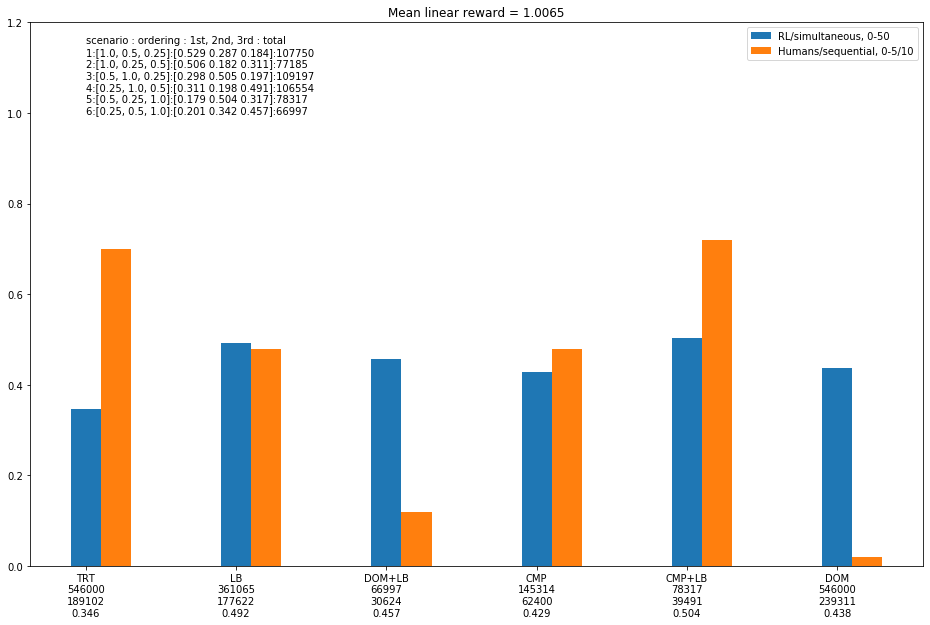

In [38]:
NF = 25
frange = tqdm(range(NF))
k=(False,'tabular')
if SEQ == True:
    sample = hist = vote_histories_seq[k]    
else:
    sample = hist = vote_histories[k]
fig, ax = plt.subplots(figsize=(16, 10))
anim = animation.FuncAnimation(fig, plot_function, frames=frange, blit=False, repeat=False)

In [39]:
anim

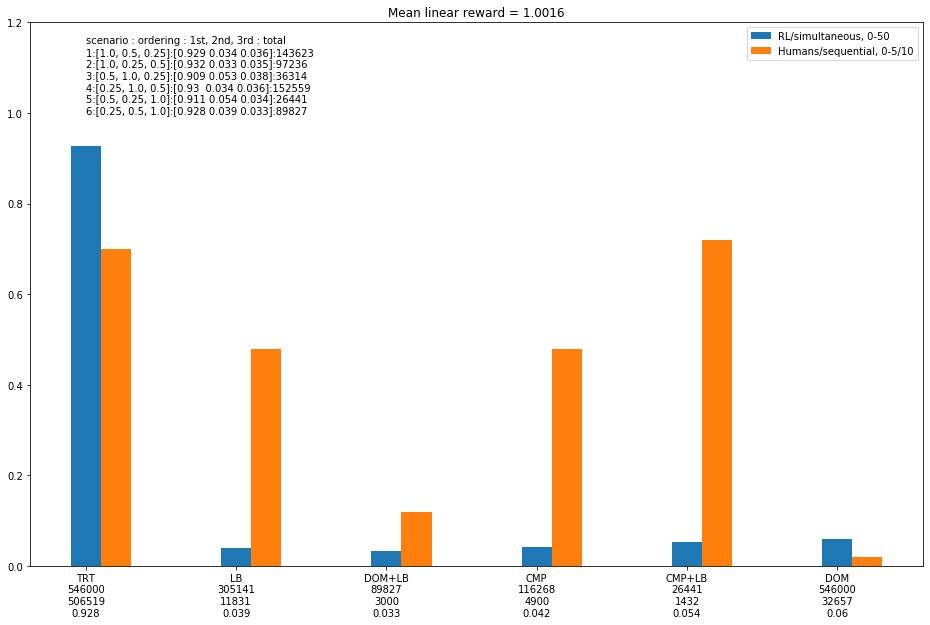

In [40]:
NF = 25
frange = tqdm(range(NF))
k=(False,'tabular_truthful')
if SEQ == True:
    sample = hist = vote_histories_seq[k]
else:    
    sample = hist = vote_histories[k]
fig, ax = plt.subplots(figsize=(16, 10))
anim = animation.FuncAnimation(fig, plot_function, frames=frange, blit=False, repeat=False)

In [41]:
anim

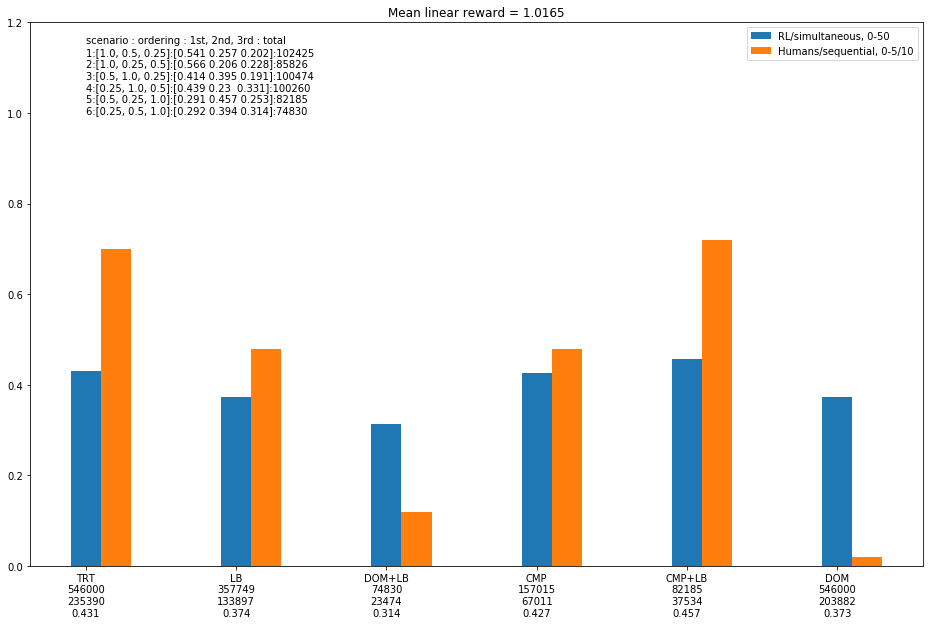

In [42]:
NF = 25
frange = tqdm(range(NF))
k=('Actions_now','DQN')
if SEQ == True:
    sample = hist = vote_histories_seq[k]
else:    
    sample = hist = vote_histories[k]
fig, ax = plt.subplots(figsize=(16, 10))
anim = animation.FuncAnimation(fig, plot_function, frames=frange, blit=False, repeat=False)

In [43]:
anim

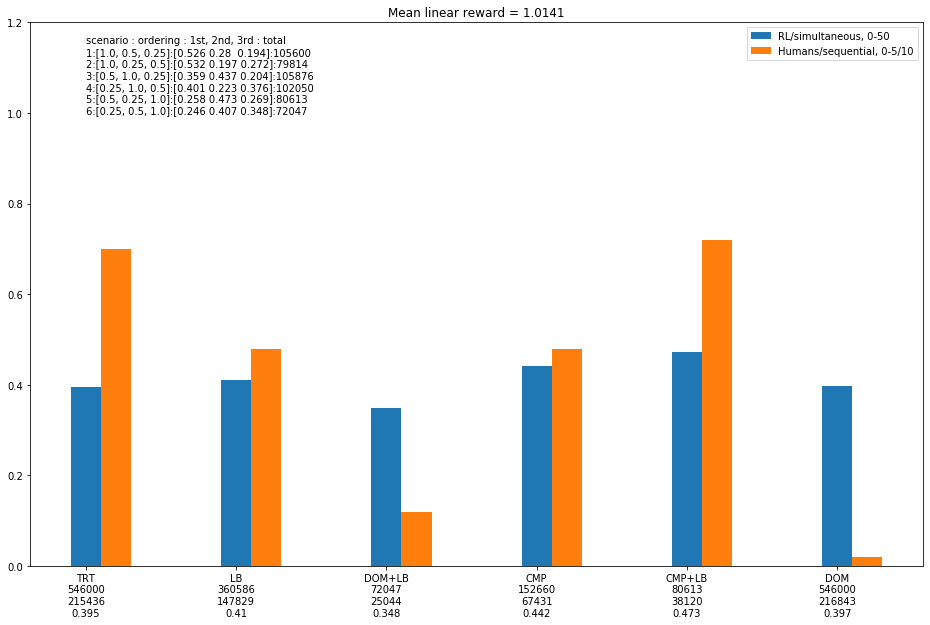

In [44]:
NF = 25
frange = tqdm(range(NF))
k=(False,'DQN')
if SEQ == True:
    sample = hist = vote_histories_seq[k]
else:    
    sample = hist = vote_histories[k]
fig, ax = plt.subplots(figsize=(16, 10))
anim = animation.FuncAnimation(fig, plot_function, frames=frange, blit=False, repeat=False)

In [45]:
anim